In [35]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier



In [36]:
import pickle
# Save model
def save_model(file_name, model):
    with open('model/'+file_name,'wb') as f:
        pickle.dump(model,f)
    f.close()

# Load model
def load_model(file_name):
    with open('model/'+file_name,'rb') as f:
        model = pickle.load(f)
    f.close()
    return model

In [37]:
#   Read raw data
data_path = 'datasets\CIC IoT 2023\\'
file_no = random.randrange(0,169)
train_file = f'part-{file_no:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv'  # largest file in datasets
df = pd.read_csv(data_path+train_file)
print(file_no)

45


In [38]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)

df.drop(single_value_cols,axis=1, inplace=True)     #    Drop all single value columns

In [39]:
### Use this code to demonstrate the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
corr.style.background_gradient(cmap='coolwarm')

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ack_count,syn_count,fin_count,urg_count,rst_count,HTTP,HTTPS,DNS,SSH,TCP,UDP,ARP,ICMP,IPv,LLC,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
flow_duration,1.000000,0.009355,0.003666,0.027936,0.001424,0.001424,0.000078,0.005969,0.008140,0.005989,0.004192,0.012790,0.002989,0.001123,0.005008,0.020445,0.017205,0.003337,0.009560,0.017412,0.047173,0.005918,0.010138,0.000134,0.008717,0.001383,0.001383,0.007393,0.002066,0.014609,0.006458,0.016031,0.006623,0.005062,0.004919,0.009846,0.016021,0.007248,0.064698,0.004927
Header_Length,0.009355,1.000000,0.046566,0.334131,0.011647,0.011647,0.000734,0.051203,0.085580,0.052439,0.031246,0.190558,0.048348,0.000593,0.053296,0.517304,0.758181,0.014220,0.291379,0.001198,0.000997,0.025009,0.107894,0.001209,0.074492,0.001503,0.001503,0.406088,0.338958,0.390237,0.424304,0.329711,0.422677,0.012769,0.014951,0.413898,0.329423,0.231152,0.270928,0.014773
Protocol Type,0.003666,0.046566,1.000000,0.013382,0.020497,0.020497,0.001502,0.105027,0.174489,0.107560,0.105564,0.119392,0.105163,0.161611,0.111926,0.021428,0.032399,0.076674,0.075299,0.006103,0.001770,0.388940,0.448878,0.005793,0.398171,0.006523,0.006523,0.324165,0.582626,0.137059,0.334697,0.029059,0.335445,0.003530,0.000845,0.446197,0.029069,0.024729,0.027275,0.000956
Duration,0.027936,0.334131,0.013382,1.000000,0.008177,0.008177,0.000735,0.049076,0.077577,0.039812,0.012606,0.310667,0.030777,0.099117,0.032572,0.267863,0.455147,0.021921,0.407820,0.026074,0.002107,0.070508,0.035023,0.021091,0.061185,0.018484,0.018484,0.255480,0.096042,0.345849,0.257729,0.342982,0.216177,0.017234,0.018041,0.239796,0.342786,0.235030,0.442437,0.017948
Rate,0.001424,0.011647,0.020497,0.008177,1.000000,1.000000,0.000396,0.000377,0.026444,0.000999,0.009265,0.015660,0.001196,0.031696,0.002472,0.006788,0.009675,0.003494,0.013992,0.000493,0.000599,0.038935,0.037672,0.000554,0.009295,0.000796,0.000796,0.007597,0.004353,0.009441,0.007975,0.008880,0.007856,0.000963,0.000367,0.007878,0.008875,0.006209,0.009094,0.000379
Srate,0.001424,0.011647,0.020497,0.008177,1.000000,1.000000,0.000396,0.000377,0.026444,0.000999,0.009265,0.015660,0.001196,0.031696,0.002472,0.006788,0.009675,0.003494,0.013992,0.000493,0.000599,0.038935,0.037672,0.000554,0.009295,0.000796,0.000796,0.007597,0.004353,0.009441,0.007975,0.008880,0.007856,0.000963,0.000367,0.007878,0.008875,0.006209,0.009094,0.000379
Drate,0.000078,0.000734,0.001502,0.000735,0.000396,0.000396,1.000000,0.001345,0.008577,0.001378,0.001354,0.001640,0.001381,0.009843,0.001444,0.000382,0.000524,0.000519,0.006405,0.000048,0.000029,0.003788,0.002275,0.000032,0.001946,0.000042,0.000042,0.001242,0.001185,0.001088,0.001288,0.000924,0.001288,0.000063,0.000025,0.001389,0.000924,0.000472,0.001695,0.000024
fin_flag_number,0.005969,0.051203,0.105027,0.049076,0.000377,0.000377,0.001345,1.000000,0.156832,0.975619,0.094902,0.114550,0.986899,0.151836,0.936070,0.026528,0.036365,0.039792,0.007064,0.003382,0.002048,0.265399,0.159389,0.002226,0.136366,0.002961,0.002961,0.086077,0.082759,0.073421,0.089193,0.062048,0.089223,0.003993,0.001522,0.095888,0.062004,0.032009,0.097227,0.001474
syn_flag_number,0.008140,0.085580,0.174489,0.077577,0.026444,0.026444,0.008577,0.156832,1.000000,0.160677,0.157905,0.178822,0.159623,0.829464,0.137942,0.044370,0.060940,0.074204,0.021554,0.005627,0.003407,0.441593,0.265204,0.003704,0.226897,0.004927,0.004927,0.141925,0.136393,0.121038,0.147143,0.102502,0.147184,0.001457,0.002277,0.156218,0.102428,0.053884,0.114492,0.002266
rst_flag_number,0.005989,0.052439,0.107560,0.039812,0.000999,0.000999,0.001378,0.975619,0.160677,1.000000,0.097228,0.104382,0.962944,0.138761,0.954230,0.026910,0.037126,0.044616,0.004479,0.003465,0.002098,0.271906,0.163296,0.002281,0.139709,0.003034,0.003034,0.087767,0.084752,0.074491,0.091042,0.062796,0.091006,0.004726,0.002326

In [40]:
def get_high_corr_cols(df:pd.DataFrame, threshold):
    cols = []
    df_col = df.columns
    c = {i:[] for i in df_col}
    corr = df.corr().abs().to_numpy()
    for i,corr_i in enumerate(corr):
        for j, corr_i_j in enumerate(corr_i):
            if(corr_i_j > threshold and i!=j):
                c[df_col[i]].append(df_col[j])
    for i in c:
        if(i not in cols and c[i]!=[]):
            cols.extend(c[i])
    return cols

# high_corr_cols = ['Srate', 'fin_flag_number', 'rst_flag_number', 'LLC', 'Std', 'Number', 'Magnitue', 'Radius', 'Weight']
high_corr_cols = get_high_corr_cols(df.iloc[:,:-1], 0.9)
df.drop(high_corr_cols,axis=1, inplace=True)

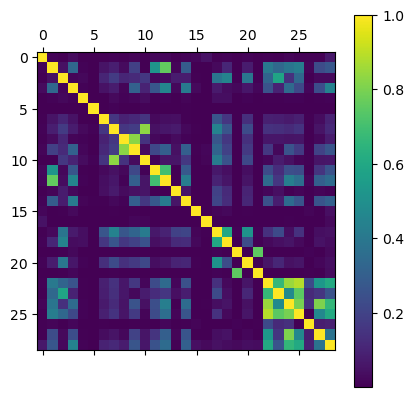

In [41]:
# Use this to get simplified correlation matrix 
new_corr =  df.iloc[:,:-1].corr().abs()
plt.matshow(new_corr)
plt.colorbar()
plt.show()

In [42]:
# Use this for standardize custom columns of dataframe
# NOTE: Remember to use the scaler with the test data to scale the data
def custom_col_standardize(df: pd.DataFrame, cols:list = 'all'):
    scalar = StandardScaler()
    scaled_data = df
    if cols == 'all':
        scaled_data.iloc[:,:-1] = pd.DataFrame(scalar.fit_transform(df.iloc[:,:-1])) 
    else:
        scaled_data.iloc[:,cols] = pd.DataFrame(scalar.fit_transform(df.iloc[:,cols])) 
    return scalar, scaled_data

In [43]:
sub_df = df    # use .sample(n) to get random n row from data frame to create sub_data
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value
X = sub_df.iloc[:,:-1].to_numpy()
Y = sub_df.iloc[:,-1].to_numpy()

C:\Users\trung\AppData\Local\Temp\ipykernel_18860\2957049766.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(1)] # remove nan, inf, -inf value


In [44]:
def convert_label_to_class_label(Y :np.ndarray):
    Y_class = []
    c = {'DDoS-ICMP_Flood': 'DDos', 'DDoS-RSTFINFlood': 'DDos', 'DDoS-SYN_Flood': 'DDos', 'DDoS-SynonymousIP_Flood': 'DDos', 'DDoS-UDP_Flood': 'DDos', 'DDoS-PSHACK_Flood': 'DDos', 'DDoS-UDP_Fragmentation': 'DDos', 'DDoS-TCP_Flood': 'DDos', 'DDoS-ICMP_Fragmentation': 'DDos', 'DDoS-HTTP_Flood': 'DDos', 'DDoS-ACK_Fragmentation': 'DDos', 'DDoS-SlowLoris': 'DDos', 'DoS-UDP_Flood': 'Dos', 'DoS-TCP_Flood': 'Dos', 'DoS-SYN_Flood': 'Dos', 'DoS-HTTP_Flood': 'Dos', 'Recon-HostDiscovery': 'Recon', 'Recon-PortScan': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PingSweep': 'Recon', 'VulnerabilityScan': 'Recon', 'Uploading_Attack': 'Recon', 'SqlInjection': 'Web-based', 'CommandInjection': 'Web-based', 'Backdoor_Malware': 'Web-based', 'XSS': 'Web-based', 'MITM-ArpSpoofing': 'Spoofing', 'DNS_Spoofing': 'Spoofing', 'BrowserHijacking': 'Spoofing', 'DictionaryBruteForce': 'Bruteforce', 'Mirai-greeth_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'BenignTraffic': 'Benign'}
    for i in Y:
        Y_class.append(c[i])
    return np.array(Y_class)


Y_class = convert_label_to_class_label(Y)

In [45]:
# This data for training detailed network attack 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))

# This data for training network attack by category
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X,Y_class,test_size=0.2, random_state=random.randint(1,999))

print(X_train.shape,X_test.shape)

(197832, 29) (49458, 29)


In [46]:
# Create model using SVM to classify specific attacks
# Use n_components='mle' to auto guess the dimension else speficy the dimension with int.

SVM_class_clf = make_pipeline(StandardScaler(),PCA(n_components='mle'), SGDClassifier())
SVM_class_clf.fit(X_train_class, Y_train_class)               

save_model('SVM_class.pkl', SVM_class_clf)

In [57]:
SVM_clf = make_pipeline(StandardScaler(),PCA(n_components=20), SGDClassifier())
SVM_clf.fit(X_train, Y_train) 
save_model('SVM.pkl', SVM_clf)

In [48]:
RF_clf = RandomForestClassifier()
RF_clf.fit(X_train,Y_train)
save_model('RF.pkl', RF_clf)

In [49]:
RF_class_clf = RandomForestClassifier()
RF_class_clf.fit(X_train_class,Y_train_class)
save_model('RF_class.pkl', RF_class_clf)

In [50]:

SVM_Y_predict_class = SVM_class_clf.predict(X_test_class)
print("SVM class model accuracy:", metrics.accuracy_score(Y_test_class, SVM_Y_predict_class))


SVM class model accuracy: 0.814630595656921


In [58]:
SVM_Y_predict = SVM_clf.predict(X_test)
print("SVM model accuracy:", metrics.accuracy_score(Y_test, SVM_Y_predict))

SVM model accuracy: 0.7823203526224272


In [52]:
RF_Y_predict_class = RF_class_clf.predict(X_test_class)
print("Random forest class model accuracy:", metrics.accuracy_score(Y_test_class, RF_Y_predict_class))

Random forest class model accuracy: 0.9941364389987464


In [53]:


RF_Y_predict = RF_clf.predict(X_test)
print("Random forest model accuracy:", metrics.accuracy_score(Y_test, RF_Y_predict))


Random forest model accuracy: 0.9923975898742368


In [54]:
# Cross-validation


df2 = pd.concat([pd.read_csv(data_path+f'part-{x:05d}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv') for x in [random.randrange(169) for i in range(10)]])
print(df2.shape)

(2843096, 47)


In [55]:
df2.drop(single_value_cols,axis=1, inplace=True)
df2.drop(high_corr_cols,axis=1, inplace=True) 
X_future_test = df2.iloc[:,:-1].to_numpy()

Y_future_test = df2.iloc[:,-1].to_numpy()
Y_future_test_class = convert_label_to_class_label(Y_future_test)

# Use any model here
Y_future_predict = SVM_clf.predict(X_future_test)

In [56]:
# Check accuracy here
print("SVM class model accuracy:", metrics.accuracy_score(Y_future_test, Y_future_predict))

SVM class model accuracy: 0.6864917681288286
